In the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb) post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce several concepts as needed. These include:
* hierarchical models sometimes referred to as multilevel or partially pooled models,
* varying effects,
* gaussian processes to introduce inference on potential covariance between unobserved variables (parameters).

In [2]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot, jointplot
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler

In [3]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18

Load the training dataset. The rrs data was imputed where necessary from adjacent bands, either by direct assignment or via linear modeling (regression). This step can be found [here](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb).

In [4]:
df = pd.read_pickle('./pickleJar/df_log.pkl')

In [5]:
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 38 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
lat             4459 non-null float64
lon             4459 non-null float64
etopo2_l        4459 non-null float64
oisst           4459 non-null float64
sal_l           2511 non-null float64
rrs411_l        4293 non-null float64
rrs443_l        4456 non-null float64
rrs489_l        4422 non-null float64
rrs510_l        4207 non-null float64
rrs555_l        4453 non-null float64
rrs670_l        3822 non-null float64
mxBl_l          4459 non-null float64
mxBlId          4459 non-null object
mxBlCat         4459 non-null int8
mxBlColor       4459 non-null object
mxBl2_l         4459 non-null float64
mxBl2Id         4459 non-null object
mxBl2Cat        4459 non-null int8
mxBl2Color      4459 non-null object
provCode        4459 non-null object
provNum         4459 non-null int64
provCat         4459 non-n

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


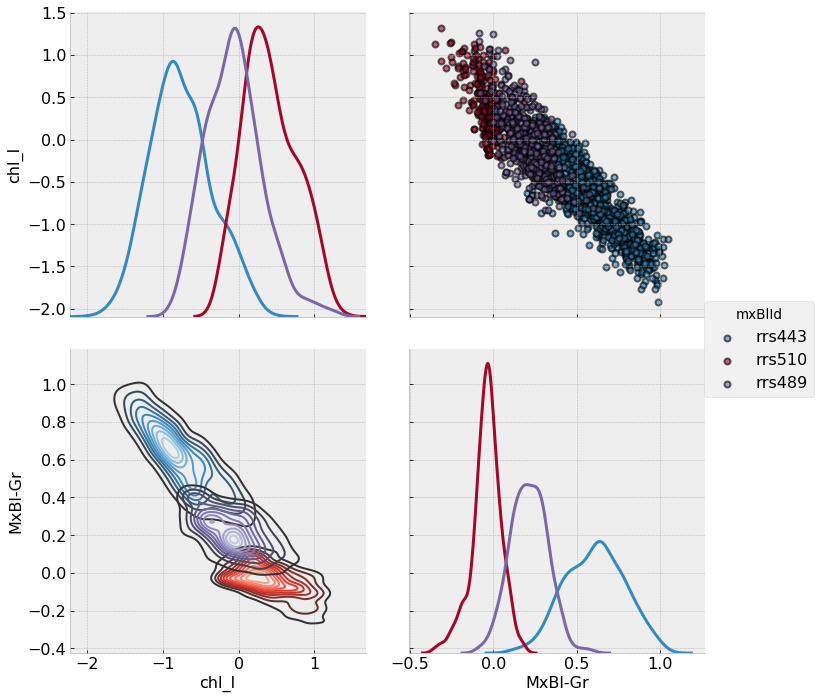

In [7]:
g = PairGrid(df.dropna(), vars=['chl_l', 'MxBl-Gr'], size=5, diag_sharey=False,
             hue='mxBlId',
             hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]});
g = g.map_upper(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
g = g.map_diag(kdeplot, lw=3)
g = g.map_lower(kdeplot);
g.add_legend();

The first thing that we can see from the imputation of the data, documented in an [earlier notebook](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb), is that the pattern in the data no longer supports necessarily a high order polynomial such as OC4. Instead, I will model the band contribution as a simpler and more readily interpretable first order regression on $log(max(blue)) - log(green)$.
<br>
The data also shows good separability with respect to the blue band used in the ratio; both in terms of chlorophyll and band ratio distributions.<br> This clustering scheme can be used to add information to the data fit. As such it will be part of the hierarchical model architecture presented below.
<br>
Another source of information that can be used for clustering is location. A simple and familiar scheme that can be used is Longhurst biogeographical province distribution.
 For context, the Longhurst map looks as follows:
<img src='figJar/lhurstbiogeog.jpg'>
<br>
An exploratory plot depicting the data distribution by province is available here.

The relationship of the various models proposed with chl_l, including the legacy OC4 algorithm, given the new augmented dataset fail to justify anything but a one degree polynomial. Another motivation to refrain from compounding the predictor variables is the interpretability the associated model parameters, the interpretability of which thus remains feasible. This does not preclude having to deal with potentially complicated relationships between predictor and predicted variables. A better way to address complexity is to use more predictor variables, and increase the flexibility of the models tested by using clustering within the data. Such flexibility can be achieved with the use of hierarchical models.

### Bayesian Hierarchical Models

Quoting from Betancourt & Girolami (2013):
"Hierarchical models are defined by the organization of a model's parameters into exchangeable groups, and the resulting conditional independencies between those groups."

Inference in a hierarchical model is conducted on multiple levels with cluster-specific parameters  with one or more common priors,  referred to as *hyper-priors*. Hyper-priors constitute a link through which information between clusters can flow during model fitting.

Structurally, and unlike models seen in [the earlier post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb), hierarchical models have:

    * one set of priors for each cluster
    * a common set of priors for the cluster priors. These hyperpriors are the constructs that allow information to flow between the different clusters.

I will illustrate the above with a diagram for the models. As shown above, there are three clusterings to choose from, including *mxblID*, *biome*, and *province*. Based on earlier diagnostics I will use *mxblID* and *province*. Note that even when max(blue) is not included in the predictor variable used, it still represent a potentially important piece of information on each observation. I therefore include it regardless of the model being fit.


### Varying intercepts models

Below is a diagram depicting a hierachical model, where the linear regression includes a cluster-specific intercepts. **Varying intercept** (hereafter VI) models, these models a cluster specific-baseline (in this case in chlorophyll) while assuming a sufficently unique as to be common relationship to the predictor variables, represented by single slope parameters. 

In [36]:
# getting relevant data:
d_ = df[['provCat', 'mxBlCat', 'MxBl-Gr', 'chl_l']].dropna()
print(d_.shape)

(4126, 4)


In [41]:
d_.describe()

,provCat,mxBlCat,MxBl-Gr,chl_l
count,4126.000000,4126.000000,4126.000000,4126.000000
mean,17.384149,0.873243,0.273775,-0.112434
std,13.943419,0.828391,0.314858,0.688037
min,0.000000,0.000000,-0.398402,-1.920819
25%,2.000000,0.000000,0.009346,-0.632342
50%,10.000000,1.000000,0.251213,-0.116825
75%,31.000000,2.000000,0.515516,0.332438
max,44.000000,2.000000,1.079671,1.891341


In [ ]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
predictor = d_['MxBl-Gr'].values
predicted = d_['chl_l'].values

In [60]:
# Standardizing the input
std_s = StandardScaler()
predictor_s = std_s.fit_transform(predictor.reshape(-1, 1))

In [91]:
with pm.Model() as mdl_bl:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2)
    #priors
    a_blue = pm.Normal('a_blue', mu=mu_a, sd=sigma_a, shape=n_blues)
    b_blue = pm.Normal('b_blue', mu=mu_b, sd=sigma_b, shape=n_blues)
    
    #forward model & model error
    mu_ = a_blue[blueIdx] + b_blue[blueIdx] * predictor
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_blue, a_blue, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████| 6000/6000 [00:35<00:00, 169.12it/s]
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.656745617268, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


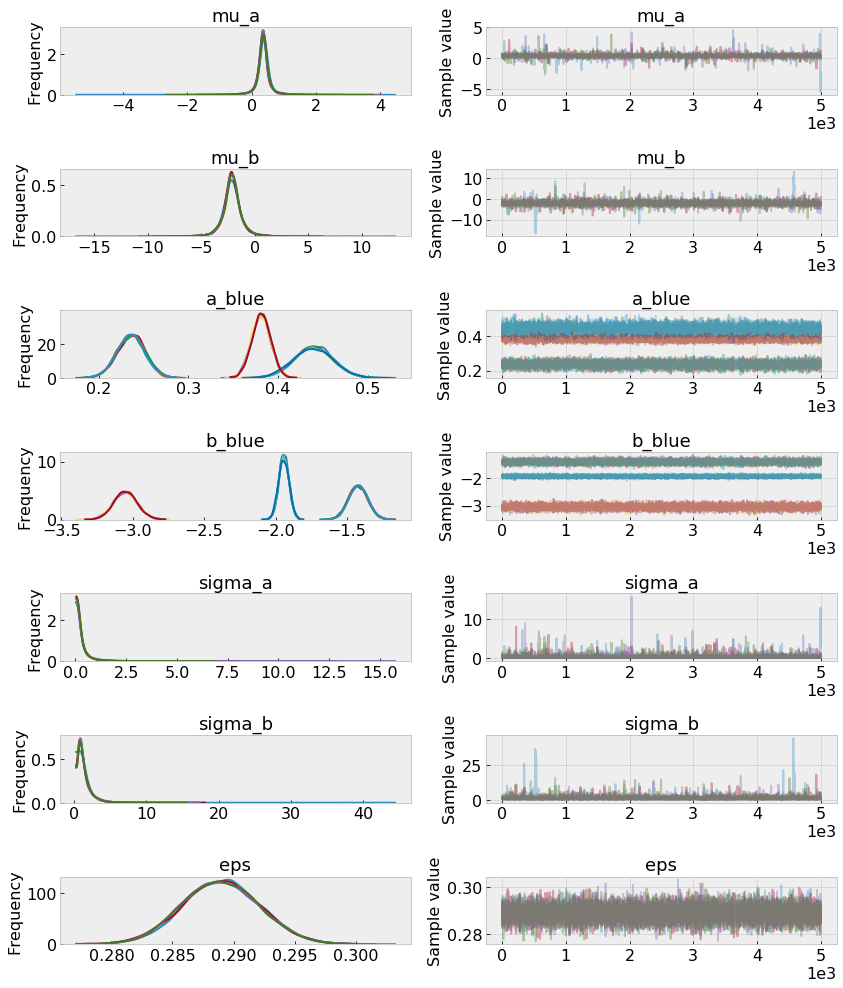

In [92]:
pm.traceplot(trace_bl);

In [102]:
pm.summary(trace_bl)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.351131,0.324709,0.005776,-0.222780,0.926108,72.0,0.999994
mu_b,-2.118935,1.133586,0.020654,-4.033817,0.073128,2438.0,1.000028
a_blue__0,0.439557,0.021792,0.000242,0.396198,0.481885,9063.0,1.000041
a_blue__1,0.236110,0.015627,0.000151,0.205302,0.266789,12656.0,1.000199
a_blue__2,0.381222,0.010641,0.000090,0.359901,0.401573,12819.0,1.000131
b_blue__0,-1.942269,0.035933,0.000398,-2.012606,-1.871742,8962.0,1.000051
b_blue__1,-1.421843,0.066257,0.000695,-1.547880,-1.288383,11432.0,1.000170
b_blue__2,-3.051962,0.081177,0.000606,-3.213903,-2.895612,12037.0,1.000139
sigma_a,0.346953,0.489236,0.007585,0.031926,1.091535,164.0,1.000105
sigma_b,1.490382,1.397039,0.033940,0.358356,3.501328,1919.0,1.001847


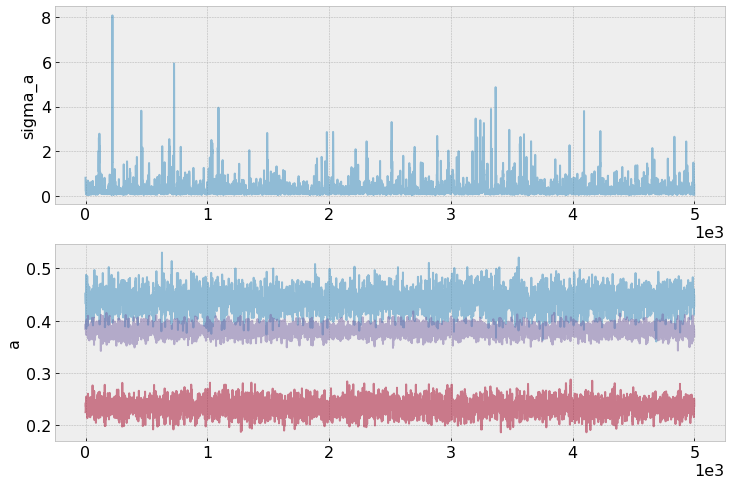

In [103]:
_, ax = pl.subplots(nrows=2, figsize=(12,8))
ax[0].plot(trace_bl.get_values('sigma_a', chains=1), alpha=.5);
ax[0].set_ylabel('sigma_a')
ax[1].plot(trace_bl.get_values('a_blue', chains=1), alpha=.5);
ax[1].set_ylabel('a');

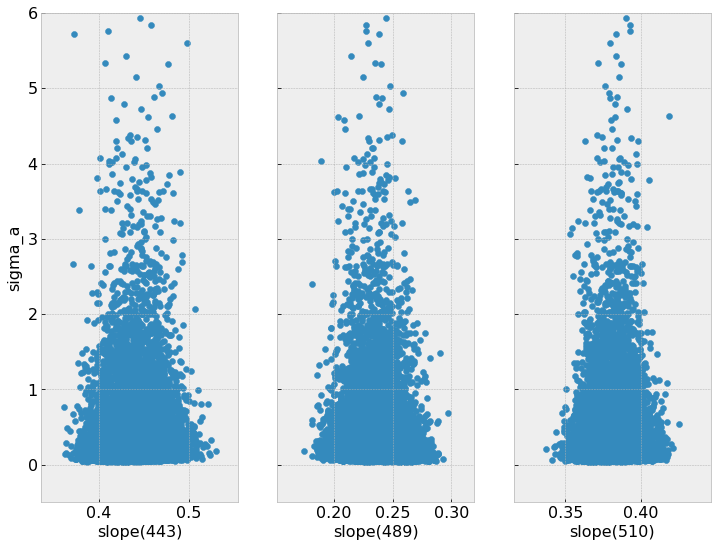

In [104]:
ds = pm.trace_to_dataframe(trace_bl, varnames=['a_blue', 'sigma_a'])
_, ax = pl.subplots(ncols=3, figsize=(12, 9), sharey=True)
for i, blbnd in enumerate(['443','489', '510']):
    ax[i].scatter(ds['a_blue__%d' %i].values, ds.sigma_a.values)
    ax[i].set_xlabel(f'slope({blbnd})')
    ax[i].set_ylim((-.5, 6))
ax[0].set_ylabel('sigma_a');

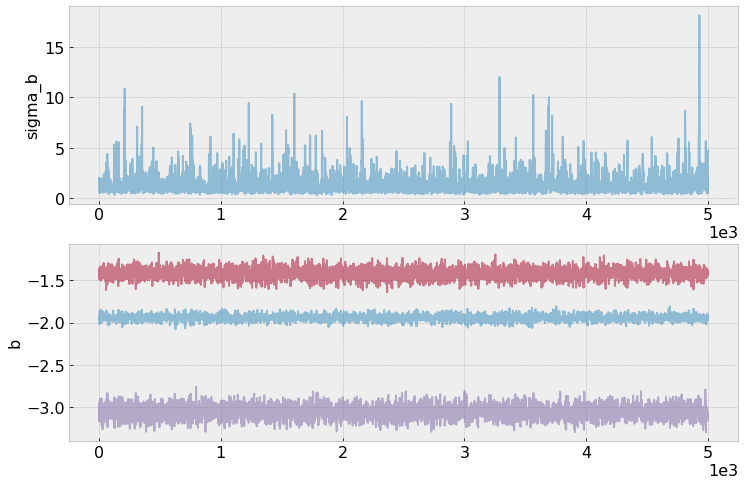

In [96]:
_, ax = pl.subplots(nrows=2, figsize=(12,8))
ax[0].plot(trace_bl.get_values('sigma_b', chains=1), alpha=.5);
ax[0].set_ylabel('sigma_b')
ax[1].plot(trace_bl.get_values('b_blue', chains=1), alpha=.5);
ax[1].set_ylabel('b');

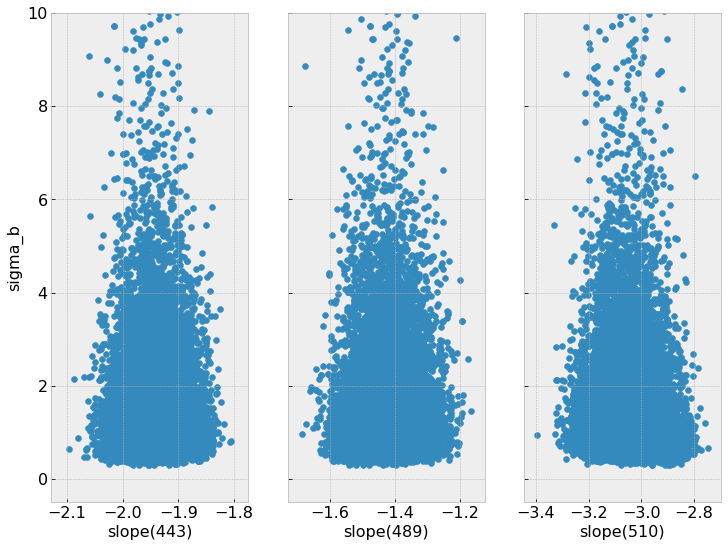

In [106]:
ds = pm.trace_to_dataframe(trace_bl, varnames=['b_blue', 'sigma_b'])
_, ax = pl.subplots(ncols=3, figsize=(12, 9), sharey=True)
for i, blbnd in enumerate(['443','489', '510']):
    ax[i].scatter(ds['b_blue__%d' %i].values, ds.sigma_b.values)
    ax[i].set_xlabel(f'slope({blbnd})')
    ax[i].set_ylim((-.5, 10))
ax[0].set_ylabel('sigma_b');

Uncentered model

In [136]:
with pm.Model() as mdl_bl_nc:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2)
    #priors
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_blues)
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_blues)
    
    a_blue = pm.Deterministic('a_blue', mu_a + a_offset * sigma_a)
    b_blue = pm.Deterministic('b_blue', mu_b + b_offset * sigma_b)
    
    #forward model & and model error
    mu_ = a_blue[blueIdx] + b_blue[blueIdx] * predictor
    eps = pm.HalfCauchy('eps', beta=5)

    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_nc = pm.sample(5000, tune=3000,
                            nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_offset, a_offset, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████| 8000/8000 [23:43<00:00,  5.62it/s]
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [117]:
pm.summary(trace_bl_nc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.342902,0.204625,0.004735,-0.120865,0.794455,1758.0,1.000488
mu_b,-2.130792,0.799907,0.017620,-4.022438,-0.556142,1978.0,1.000041
a_offset__0,0.524883,0.670016,0.011151,-0.794170,1.816729,3749.0,1.000250
a_offset__1,-0.667140,0.750079,0.016578,-2.154339,0.717984,1611.0,1.000340
a_offset__2,0.189443,0.597317,0.011783,-0.977365,1.329360,2243.0,1.000125
b_offset__0,0.190214,0.581519,0.008174,-0.950658,1.337213,6123.0,1.000212
b_offset__1,0.695217,0.669360,0.011926,-0.570332,2.024806,3538.0,1.000292
b_offset__2,-0.889748,0.721407,0.009724,-2.359332,0.437441,4897.0,1.000605
sigma_a,0.294863,0.273092,0.004209,0.038904,0.868380,4583.0,1.000547
sigma_b,1.340617,0.773176,0.031990,0.353092,3.028366,494.0,1.003633


Modeling the slope/intercept covariance and the the LKJ Correlation prior

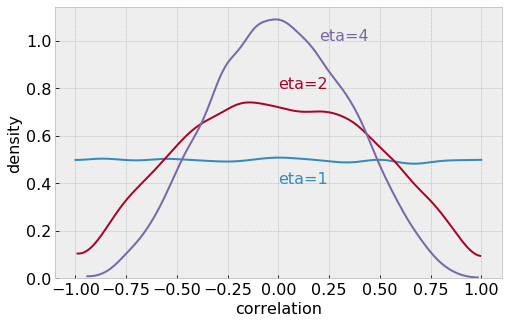

In [56]:
_, ax = pl.subplots(figsize=(8, 5))
textlocs = [[0, 0.4,], [0, 0.8], [0.2, 1]]
for i, (loc, eta) in enumerate(zip(textlocs, [1, 2, 4])):
    r = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(r, ax=ax)
    ax.text(loc[0], loc[1], f'eta={eta}', color=ax.lines[i].get_color())
ax.set_xlabel('correlation')
ax.set_ylabel('density');

In [126]:
with pm.Model() as mdl_bl_cov:
    # hyperpriors
    a_bl_hyp = pm.Normal('a_bl_hyp', 0, 10)
    b_bl_hyp = pm.Normal('b_bl_hyp', 0, 1)
    sd_dist = pm.HalfCauchy.dist(beta=2)
    
    #priors
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=4, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    
    ab_bl = pm.MvNormal('ab_bl', mu=tt.stack([a_bl_hyp, b_bl_hyp]), chol=chol,
                    shape=(n_blues, 2))
    
    # extract intercepts
    a_bl = pm.Deterministic('a_blue', ab_bl[:, 0])
    # extract slopes
    b_bl = pm.Deterministic('b_blue', ab_bl[:, 1])
    # extract correlation (rho)
    cov = tt.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # forward model & model error
    mu_ = a_bl[blueIdx] + b_bl[blueIdx] * predictor
    eps = pm.HalfCauchy('eps', beta=2)
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_cov = pm.sample(5000, tune=3000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, ab_bl, chol_cov_cholesky_cov_packed__, b_bl_hyp, a_bl_hyp]
100%|██████████| 8000/8000 [02:39<00:00, 50.19it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.906862490971, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


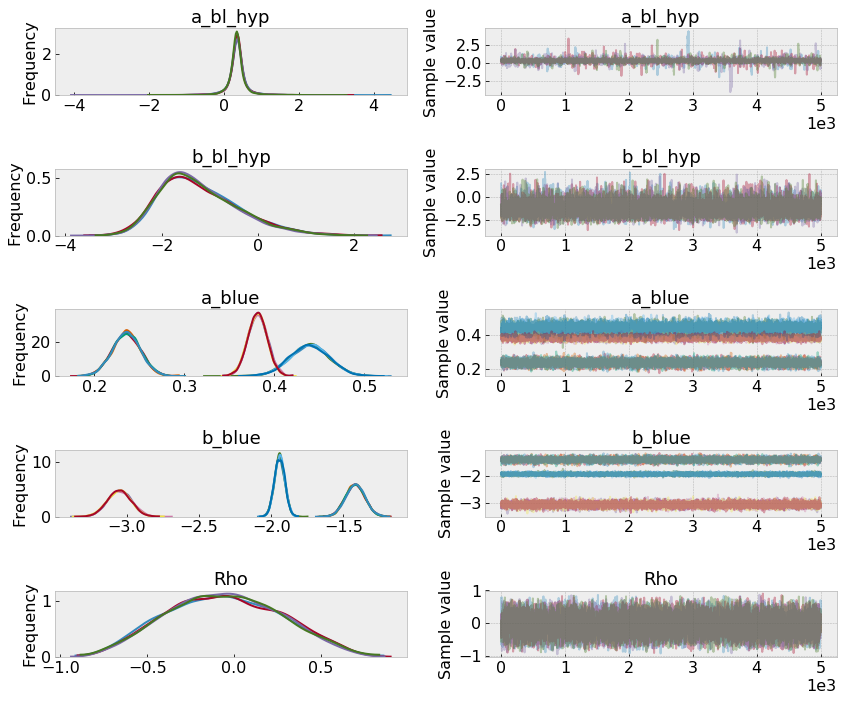

In [135]:
pm.traceplot(trace_bl_cov, varnames=['a_bl_hyp', 'b_bl_hyp', 'a_blue', 'b_blue', 'Rho']);

In [127]:
pm.summary(trace_bl_cov)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a_bl_hyp,0.342733,0.329472,0.007140,-0.244072,0.943747,1818.0,1.000543
b_bl_hyp,-1.210769,0.825436,0.008923,-2.624785,0.500706,8473.0,1.000280
ab_bl__0_0,0.439222,0.022028,0.000181,0.396888,0.482743,11404.0,0.999968
ab_bl__0_1,-1.941479,0.036252,0.000308,-2.008931,-1.867296,11290.0,0.999983
ab_bl__1_0,0.235614,0.015743,0.000127,0.204666,0.266187,12722.0,0.999971
ab_bl__1_1,-1.419345,0.066975,0.000569,-1.548095,-1.287893,13155.0,0.999991
ab_bl__2_0,0.381260,0.010858,0.000085,0.359606,0.402437,16095.0,1.000156
ab_bl__2_1,-3.050884,0.082018,0.000712,-3.210584,-2.891052,14735.0,1.000082
chol_cov__0,0.359549,0.486515,0.008293,0.031745,1.116438,2788.0,1.000338
chol_cov__1,-0.090457,0.742518,0.009891,-1.582678,1.402526,5967.0,1.000138


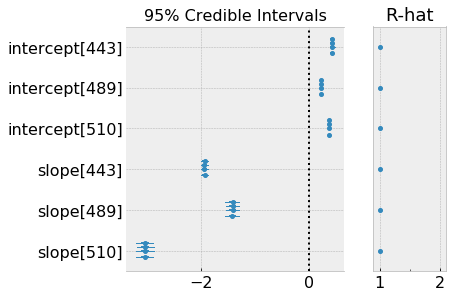

In [129]:
pm.forestplot(trace, varnames=['a_blue', 'b_blue'],
             ylabels=['intercept[443]', 'intercept[489]', 'intercept[510]',
                     'slope[443]', 'slope[489]', 'slope[510]']);

In [110]:
pm.summary(trace_bl_nc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.350769,0.156596,0.003028,-0.013685,0.691286,2575.0,1.001139
mu_b,-2.119874,0.632603,0.011110,-3.381016,-0.787262,3169.0,1.000659
a_offset__0,0.552563,0.663943,0.010382,-0.712341,1.866791,3903.0,0.999967
a_offset__1,-0.721608,0.731956,0.010595,-2.169572,0.699331,4409.0,1.000570
a_offset__2,0.194294,0.585909,0.009010,-0.945700,1.350122,3971.0,1.000037
b_offset__0,0.197862,0.560499,0.008462,-0.942531,1.266717,4170.0,1.000318
b_offset__1,0.745039,0.641501,0.009766,-0.536122,1.983156,4566.0,1.000325
b_offset__2,-0.977315,0.679085,0.009657,-2.312642,0.314645,4952.0,1.001225
sigma_a,0.246594,0.190853,0.003171,0.040409,0.660830,3267.0,1.001170
sigma_b,1.121758,0.472349,0.008630,0.402423,2.084475,2784.0,1.004998


trying other version of noncentered

In [139]:
with pm.Model() as mdl_bl_cov_nc0:
    # hyperpriors
    a_bl_hyp = pm.Normal('a_bl_hyp', 0, 10)
    b_bl_hyp = pm.Normal('b_bl_hyp', 0, 1)
    sd_dist = pm.HalfCauchy.dist(beta=2)
    
    #priors
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=4, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    
    ab_bl = pm.MvNormal('ab_bl', mu=np.zeros(2), chol=chol, shape=(n_blues, 2))
    
    # extract intercepts
    a_bl = pm.Deterministic('a_blue', ab_bl[:, 0] + a_bl_hyp)
    # extract slopes
    b_bl = pm.Deterministic('b_blue', ab_bl[:, 1] + b_bl_hyp)
    # extract correlation (rho)
    cov = tt.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # forward model & model error
    mu_ = a_bl[blueIdx] + b_bl[blueIdx] * predictor
    eps = pm.HalfCauchy('eps', beta=2)
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_cov_nc0 = pm.sample(5000, tune=3000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, ab_bl, chol_cov_cholesky_cov_packed__, b_bl_hyp, a_bl_hyp]
100%|██████████| 8000/8000 [27:13<00:00,  4.90it/s]
The number of effective samples is smaller than 10% for some parameters.


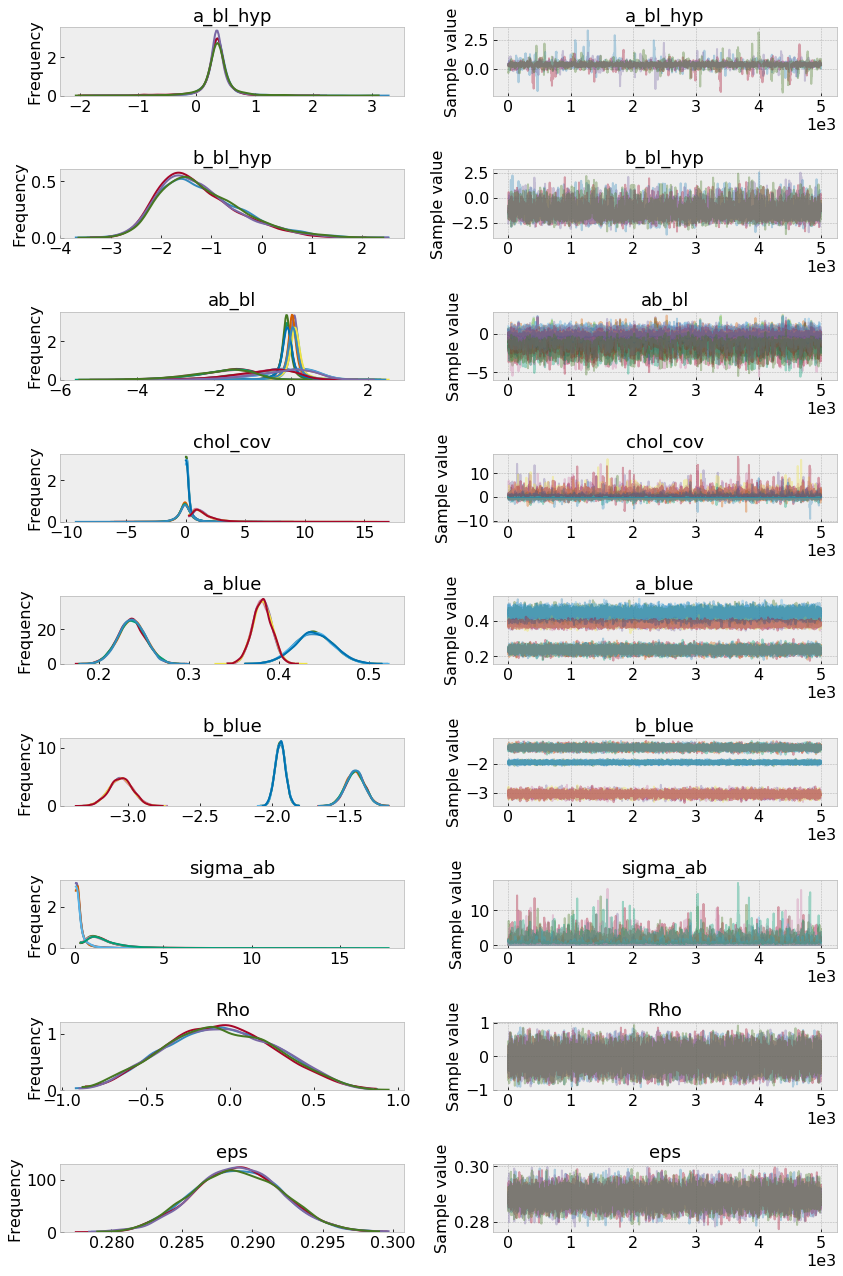

In [145]:
pm.traceplot(trace_bl_cov_nc0);

In [140]:
pm.summary(trace_bl_cov_nc0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a_bl_hyp,0.345908,0.293671,0.008482,-0.212474,0.979138,1340.0,1.004833
b_bl_hyp,-1.227356,0.807416,0.013724,-2.594414,0.459761,4076.0,1.001738
ab_bl__0_0,0.092889,0.293864,0.008472,-0.545920,0.640354,1344.0,1.004807
ab_bl__0_1,-0.713562,0.807940,0.013762,-2.431591,0.627915,4069.0,1.001743
ab_bl__1_0,-0.109918,0.293786,0.008505,-0.740635,0.447042,1337.0,1.004938
ab_bl__1_1,-0.193064,0.808451,0.013677,-1.882468,1.180428,4090.0,1.001663
ab_bl__2_0,0.035462,0.293714,0.008494,-0.605139,0.584688,1339.0,1.004855
ab_bl__2_1,-1.823552,0.813772,0.013776,-3.475382,-0.396201,4076.0,1.001766
chol_cov__0,0.346430,0.433712,0.008796,0.036530,1.096879,2344.0,1.000847
chol_cov__1,-0.067585,0.729791,0.009931,-1.521490,1.341055,5493.0,1.000222


In [113]:
with pm.Model() as mdl_bl_cov_nc:
    # hyperpriors
    a_bl_hyp = pm.Normal('a_bl_hyp', 0, 10)
    b_bl_hyp = pm.Normal('b_bl_hyp', 0, 10)
    
    #priors
    #prior for the standard deviations of intercept and slope
    sd_dist = pm.HalfCauchy.dist(beta=2)
    # cholesky decomposition of the prior of the covariance between intercept and slope
    packed_chol_blue = pm.LKJCholeskyCov('chol_cov', eta=4, n=2, sd_dist=sd_dist)
    # expand cholesky factor matrix
    chol_blue = pm.expand_packed_triangular(2, packed_chol_blue, lower=True)    
    # priors on intercept and slope
    # uncorrelated priors
    ab_blue_prior = pm.Normal('ab_blue_prior', 0, 10, shape=(2, n_blues))
    
    #induce correlation via convolution with cholesky factor 
    ab_blue = tt.dot(chol_blue, ab_blue_prior)
    # storing variables for analysis
    a_bl = pm.Deterministic('a_blue', ab_blue_prior[0])
    b_bl = pm.Deterministic('b_blue', ab_blue_prior[1])
    
    # forward model & model_error
    mu_ = a_bl[blueIdx] + b_bl[blueIdx] * predictor
    eps = pm.HalfCauchy('eps', beta=2)
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl_cov_nc = pm.sample(5000, tune=3000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, ab_blue_prior, chol_cov_cholesky_cov_packed__, b_bl_hyp, a_bl_hyp]
100%|██████████| 11000/11000 [06:42<00:00, 27.35it/s]
The acceptance probability does not match the target. It is 0.788102622589, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.903777917307, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [114]:
pm.summary(trace_bl_cov_nc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a_bl_hyp,-0.097285,9.854606,0.110569,-19.839272,18.846255,10052.0,1.000415
b_bl_hyp,-0.171867,9.887072,0.134130,-19.424204,18.967260,3485.0,1.000982
ab_blue_prior__0_0,0.441411,0.021759,0.000287,0.397427,0.483460,8166.0,1.000169
ab_blue_prior__0_1,0.234490,0.015431,0.000221,0.204822,0.265202,5221.0,0.999975
ab_blue_prior__0_2,0.380629,0.010593,0.000108,0.360343,0.401868,9014.0,0.999948
ab_blue_prior__1_0,-1.945120,0.035851,0.000489,-2.015985,-1.873849,7865.0,1.000292
ab_blue_prior__1_1,-1.415242,0.066164,0.000935,-1.538626,-1.282069,5977.0,1.000003
ab_blue_prior__1_2,-3.060671,0.081939,0.001119,-3.214156,-2.895324,5340.0,1.000185
chol_cov__0,11.627024,136.427379,1.385136,0.000223,26.404706,9678.0,1.000105
chol_cov__1,0.183962,11.731057,0.582093,-7.311803,8.125960,412.0,1.008872


In [112]:
pm.summary(trace_bl_cov_nc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a_bl_hyp,-0.069809,10.159362,0.099683,-19.971893,19.553758,12656.0,0.999903
b_bl_hyp,0.003180,1.011172,0.009343,-1.930427,1.980024,15298.0,1.000450
ab_blue_prior__0_0,0.439461,0.021976,0.000263,0.396846,0.483476,7609.0,1.000039
ab_blue_prior__0_1,0.232901,0.015722,0.000159,0.202001,0.263948,8297.0,1.000110
ab_blue_prior__0_2,0.382295,0.010658,0.000081,0.361519,0.403395,15117.0,1.000127
ab_blue_prior__1_0,-1.941955,0.036085,0.000420,-2.012814,-1.870977,7791.0,1.000010
ab_blue_prior__1_1,-1.407099,0.067221,0.000679,-1.539750,-1.277684,8249.0,1.000188
ab_blue_prior__1_2,-3.039975,0.080911,0.000712,-3.194272,-2.878911,13988.0,1.000410
chol_cov__0,11.939849,212.143183,1.688804,0.000063,24.977455,15264.0,0.999986
chol_cov__1,-0.583547,8.556821,0.283369,-6.957887,7.335725,841.0,1.006420


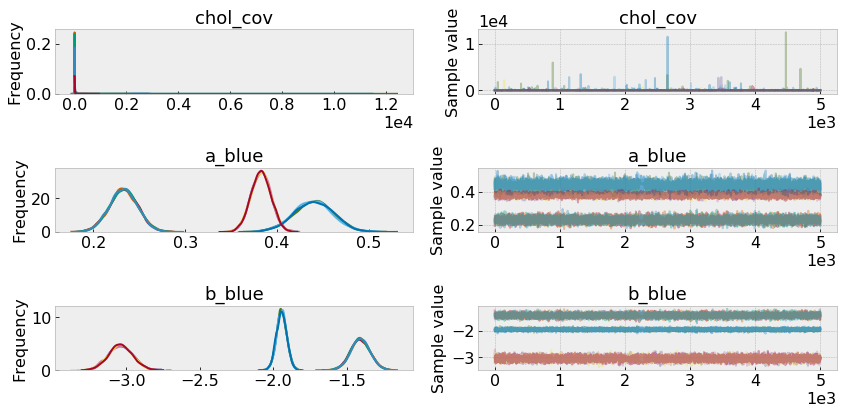

In [90]:
pm.traceplot(trace_bl_nc, varnames=['chol_cov', 'a_blue', 'b_blue']);

WAIC-based model comparison

In [147]:
traces_bl = [trace_bl, trace_bl_nc, trace_bl_cov, trace_bl_cov_nc0, trace_bl_cov_nc]
models_bl = [mdl_bl, mdl_bl_nc, mdl_bl_cov, mdl_bl_cov_nc0, mdl_bl_cov_nc]
model_names = ['mdl_bl', 'mdl_bl_nc', 'mdl_bl_cov', 'mdl_bl_cov_nc0', 'mdl_bl_cov_nc']

In [149]:
df_comp = pm.compare(traces=traces_bl, models=models_bl)
df_comp.index = [model_names[i] for i in df_comp.index]
df_comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
mdl_bl_cov_nc,1469.98,7.95,0,1,88.77,0,1
mdl_bl_cov_nc0,1470.13,8.02,0.15,0,88.74,0.45,1
mdl_bl_nc,1470.15,8.03,0.18,0,88.77,0.43,1
mdl_bl,1470.16,8.04,0.18,0,88.73,0.42,1
mdl_bl_cov,1470.35,8.15,0.38,0,88.77,0.4,1


pickling models and traces:

In [150]:
mdl_dict_bl = {nam: {'model': mdl, 'trace': trc} for nam, mdl, trc in zip(model_names,
                                                                         models_bl,
                                                                         traces_bl)}

In [151]:
mdl_dict_bl

{'mdl_bl': {'model': <pymc3.model.Model at 0x7f7219cc6a20>,
  'trace': <MultiTrace: 4 chains, 5000 iterations, 10 variables>},
 'mdl_bl_cov': {'model': <pymc3.model.Model at 0x7f7218dad780>,
  'trace': <MultiTrace: 4 chains, 5000 iterations, 11 variables>},
 'mdl_bl_cov_nc': {'model': <pymc3.model.Model at 0x7f7150623358>,
  'trace': <MultiTrace: 4 chains, 5000 iterations, 9 variables>},
 'mdl_bl_cov_nc0': {'model': <pymc3.model.Model at 0x7f71583c9400>,
  'trace': <MultiTrace: 4 chains, 5000 iterations, 11 variables>},
 'mdl_bl_nc': {'model': <pymc3.model.Model at 0x7f7158974e80>,
  'trace': <MultiTrace: 4 chains, 5000 iterations, 12 variables>}}

In [152]:
with open('./pickleJar/mdl_dict_bl.pkl', 'wb') as f:
    pickle.dump(mdl_dict_bl, f, protocol=pickle.HIGHEST_PROTOCOL)

<u>Refs:</u>

[1.](https://arxiv.org/abs/1312.0906) Betancourt, M. & Girolami, M. 2013. Hamiltonian Monte Carlo for Hierarchical Models. [arXiv:1312.0906](https://arxiv.org/abs/1312.0906)